In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import talib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from LorentzianClassification.Classfier import LorentzianClassification

# Data Preparation

In [2]:
# List of currency pairs
# currency_pairs = ["AUDUSD=X", "NZDUSD=X", "USDBRL=X", "USDCAD=X", "USDNOK=X", "USDZAR=X", 'USDJPY=X', "USDGBP=X"]
currency_pairs = ["AUDUSD=X", "NZDUSD=X", "USDBRL=X", "USDCAD=X", "USDNOK=X", "USDSGD=X", "USDZAR=X", 'USDJPY=X', "USDGBP=X", "USDCHF=X", "USDINR=X", "USDIDR=X", "USDPHP=X","USDTHB=X"]

# Start & End Date
start_date = '2013-01-01'
end_date = '2023-01-01'

# Function to fetch exchange rate
def get_exchange_rate(currency_pairs ,start, end):
    price = yf.download(currency_pairs, start=start, end=end, group_by='ticker', interval='1d')
    return price

In [3]:
FX_df = get_exchange_rate(currency_pairs, start_date, end_date)

# Flatten MultiIndex columns
FX_df.columns = ['_'.join(col).strip() for col in FX_df.columns.values]

[*********************100%***********************]  14 of 14 completed


In [4]:
pair_dict = {}
for pair in currency_pairs:
    pair_data = FX_df[[col for col in FX_df.columns if col.startswith(pair)]]
    pair_data.columns = [col.split('_')[1] for col in pair_data.columns]  # Remove ticker from column names
    pair_data = pair_data.dropna()
    pair_dict[pair] = pair_data

In [5]:
currency_pairs

['AUDUSD=X',
 'NZDUSD=X',
 'USDBRL=X',
 'USDCAD=X',
 'USDNOK=X',
 'USDSGD=X',
 'USDZAR=X',
 'USDJPY=X',
 'USDGBP=X',
 'USDCHF=X',
 'USDINR=X',
 'USDIDR=X',
 'USDPHP=X',
 'USDTHB=X']

# Lorentzian Classification Predictions

In [6]:
lc = LorentzianClassification(pair_dict['USDCAD=X'])

# lc = LorentzianClassification(
#         pair_dict['NZDUSD=X'],
#         features=[
#             LorentzianClassification.Feature("RSI", 14, 2),  # f1
#             LorentzianClassification.Feature("WT", 10, 11),  # f2
#             LorentzianClassification.Feature("CCI", 20, 2),  # f3
#             LorentzianClassification.Feature("ADX", 20, 2),  # f4
#             LorentzianClassification.Feature("RSI", 9, 2),   # f5
#         ],
#         settings=LorentzianClassification.Settings(
#             source=pair_dict['NZDUSD=X'].Close,
#             neighborsCount=8,
#             maxBarsBack=8000,
#             useDynamicExits=False
#         ),
#         filterSettings=LorentzianClassification.FilterSettings(
#             useVolatilityFilter=True,
#             useRegimeFilter=True,
#             useAdxFilter=False,
#             regimeThreshold=-0.1,
#             adxThreshold=20,
#             kernelFilter = LorentzianClassification.KernelFilter(
#                 useKernelSmoothing = False,
#                 lookbackWindow = 8,
#                 relativeWeight = 8.0,
#                 regressionLevel = 25,
#                 crossoverLag = 1,
#             )
#         ))

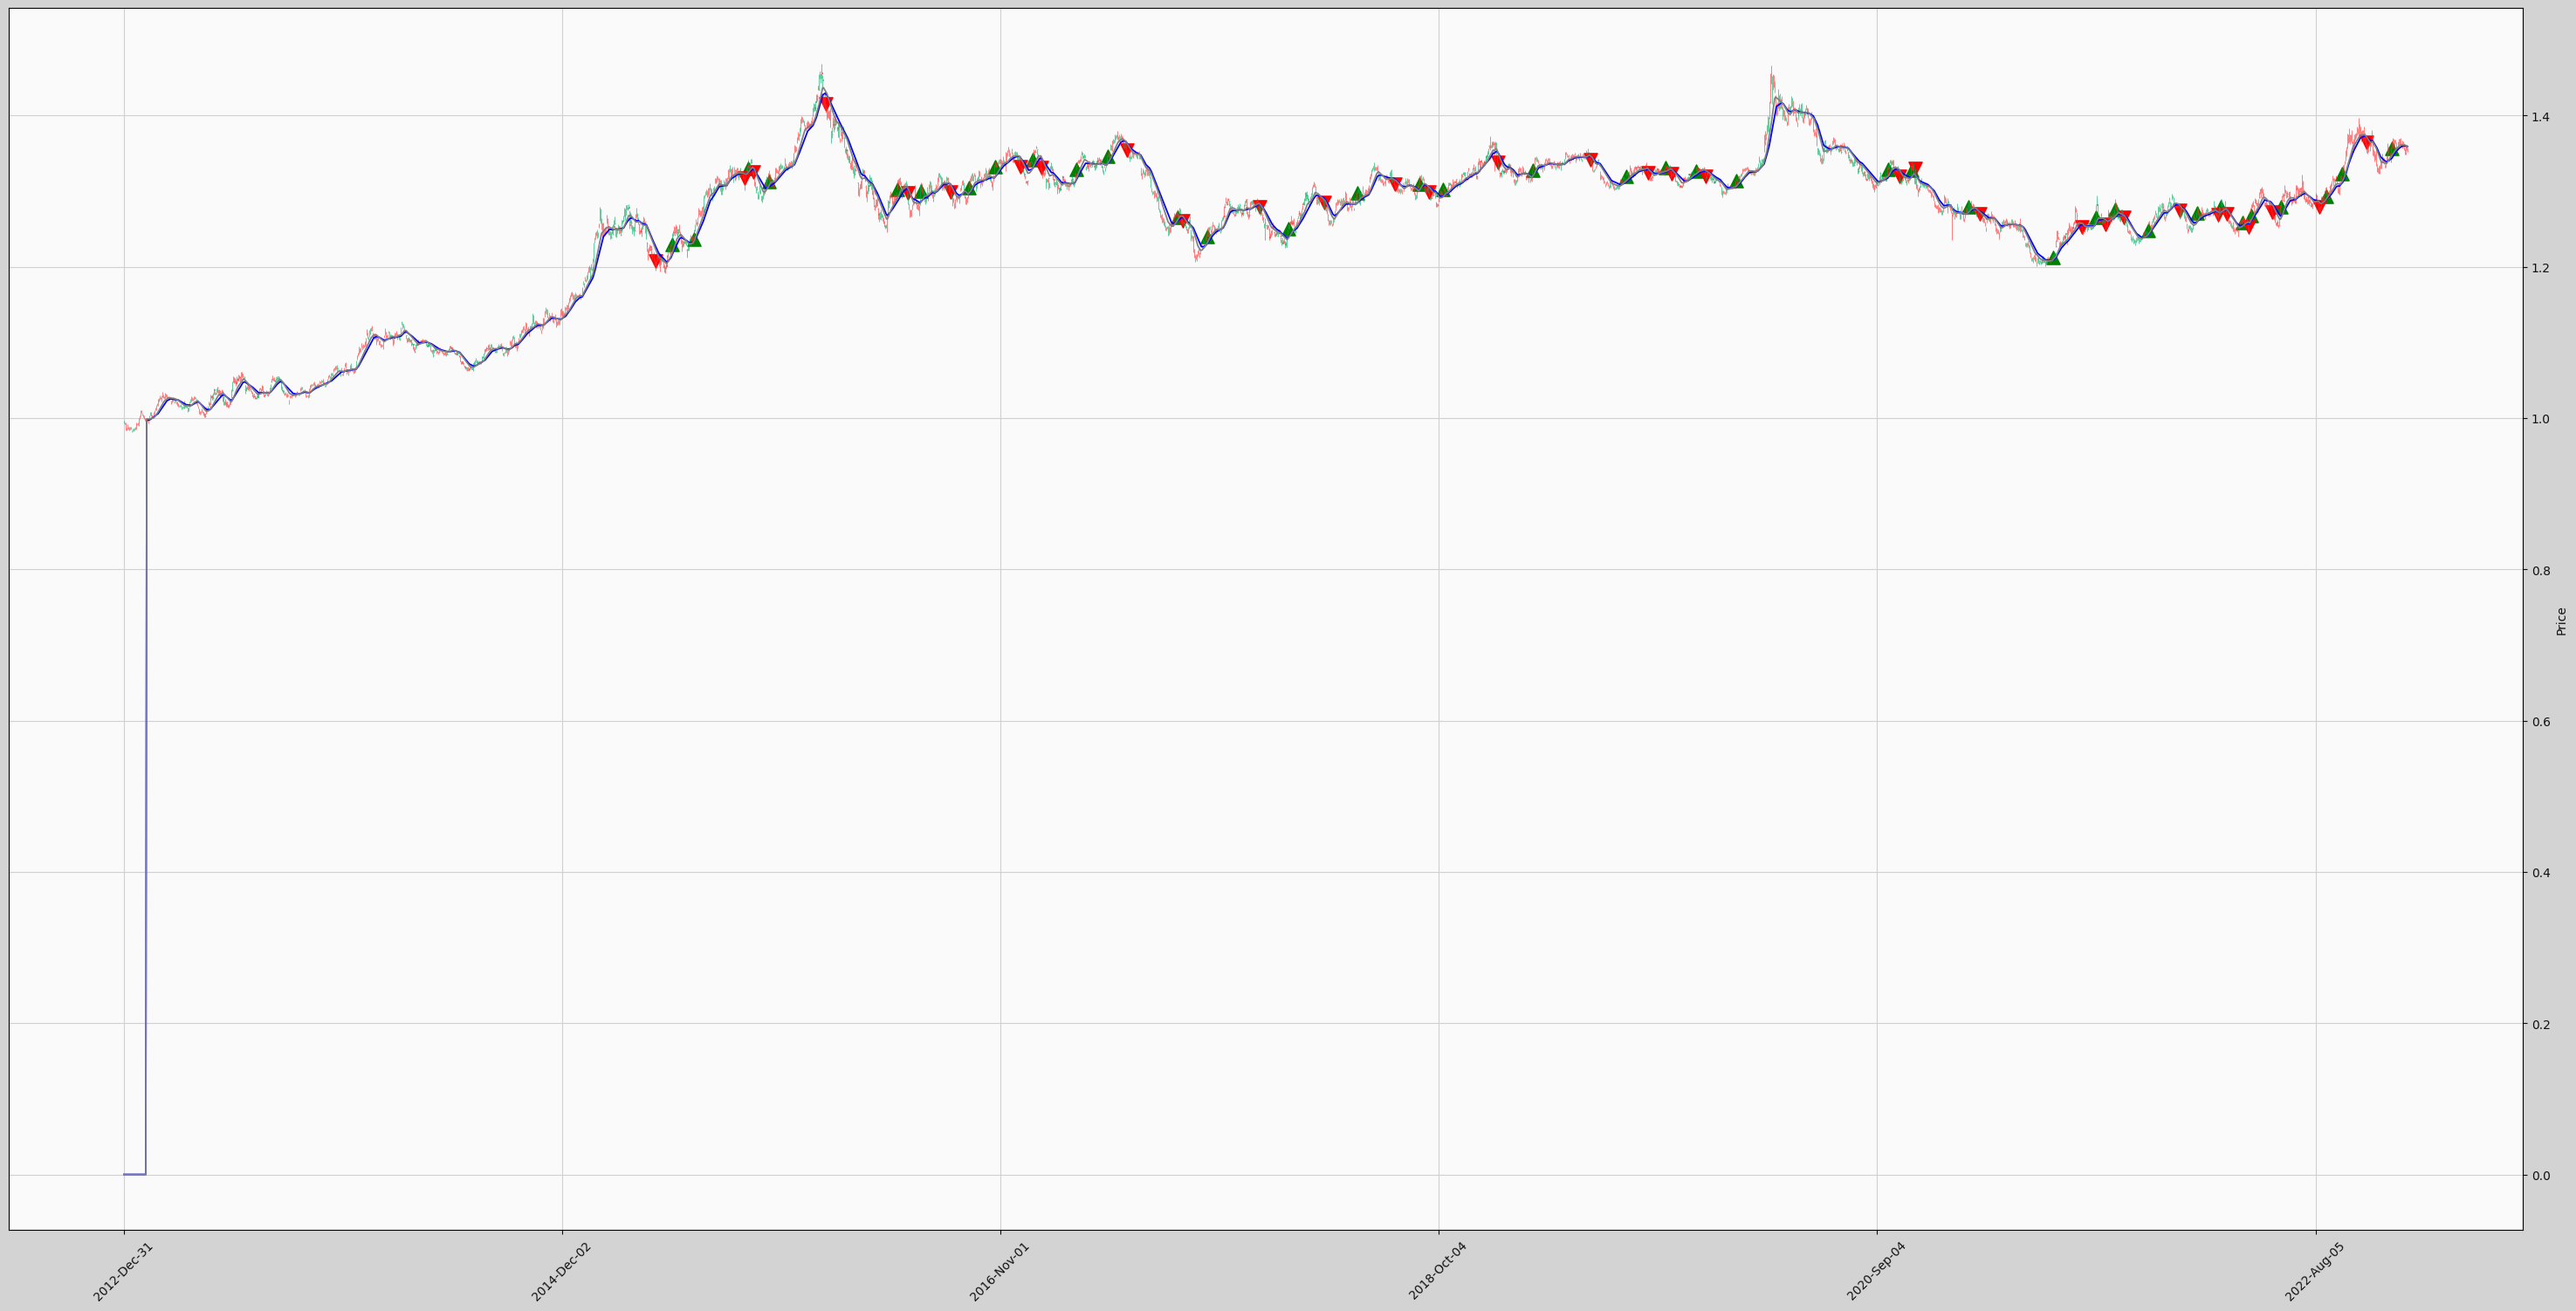

In [7]:
lc.plot()

# Backtesting

In [8]:
from backtesting import Backtest, Strategy
from backtesting.lib import TrailingStrategy, crossover

# Lorentzian

In [9]:
lc_df_all = lc.df.copy()
lc_df_all['yhat1'] = lc.yhat1

In [10]:
# Signals from LC model
def startLong():
    return lc_df_all.startLongTrade
def endLong():
    return lc_df_all.endLongTrade
def startShort():
    return lc_df_all.startShortTrade
def endShort():
    return lc_df_all.endShortTrade
def yhat1():
    return lc_df_all.yhat1

In [11]:
class LC_Hold4_Strategy(Strategy):
    def init(self):
        super().init()
        self.startlong = self.I(startLong)
        self.startshort = self.I(startShort)
        self.bars_since_buy_entry = 0
        self.bars_since_sell_entry = 0

    def next(self):
        super().next()
        if self.startlong > 0 :
            self.buy() # to add stop loss, use `sl` argument. Use `tp` for take profit
            self.bars_since_buy_entry = 0

        elif self.startshort > 0 :
            self.sell() # to add stop loss, use `sl` argument. Use `tp` for take profit
            self.bars_since_sell_entry = 0
        
        self.bars_since_buy_entry += 1
        self.bars_since_sell_entry +=1

        # Check if the number of bars since entry has reached 4
        if self.bars_since_buy_entry == 4 and self.position.is_long:
            self.position.close() 
        elif self.bars_since_sell_entry == 4 and self.position.is_short:
            self.position.close()  

In [12]:
bt_hold4 = Backtest(lc_df_all, LC_Hold4_Strategy, cash=10000, commission=0.002, trade_on_close=False)
stats_hold4 = bt_hold4.run()

In [13]:
# Iterate through all currency pairs
stats_hold4_all = pd.DataFrame()

for k,v in pair_dict.items():
    temp_lc = LorentzianClassification(v)
    temp_lc_df = temp_lc.df
    temp_lc_df['yhat1'] = temp_lc.yhat1

    def startLong():
        return temp_lc_df.startLongTrade
    def endLong():
        return temp_lc_df.endLongTrade
    def startShort():
        return temp_lc_df.startShortTrade
    def endShort():
        return temp_lc_df.endShortTrade
    def yhat1():
        return temp_lc_df.yhat1
    
    temp_bt_hold4 = Backtest(temp_lc_df, LC_Hold4_Strategy, cash=10000, commission=0.002, trade_on_close=False)
    temp_stats_bt_hold4 = temp_bt_hold4.run()
    x = pd.DataFrame(temp_stats_bt_hold4).T
    x['CCY'] = k
    stats_hold4_all = pd.concat([stats_hold4_all, x])
    

In [14]:
stats_hold4_all

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],Volatility (Ann.) [%],...,Avg. Trade [%],Max. Trade Duration,Avg. Trade Duration,Profit Factor,Expectancy [%],SQN,_strategy,_equity_curve,_trades,CCY
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,11.473523,9765.41134,10288.590425,-2.345887,-34.892136,-0.229287,2.664486,...,-0.031643,5 days 00:00:00,5 days 00:00:00,0.934485,-0.026548,-0.271787,LC_Hold4_Strategy,Equity DrawdownPct DrawdownD...,Size EntryBar ExitBar EntryPrice Exit...,AUDUSD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,11.05142,9772.353999,10553.107276,-2.27646,-22.859203,-0.22243,2.646674,...,-0.031981,5 days 00:00:00,5 days 00:00:00,0.92734,-0.027956,-0.296966,LC_Hold4_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,NZDUSD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,11.017274,9759.78493,11109.718724,-2.402151,158.403005,-0.234937,4.85367,...,-0.03372,5 days 00:00:00,5 days 00:00:00,0.966897,-0.021326,-0.18012,LC_Hold4_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDBRL=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,10.207214,9294.891748,10488.635777,-7.051083,36.283188,-0.704577,1.913365,...,-0.10908,5 days 00:00:00,5 days 00:00:00,0.717927,-0.105881,-1.07224,LC_Hold4_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDCAD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,10.130468,9038.854405,10139.647055,-9.611456,77.191931,-0.972419,4.909938,...,-0.153107,5 days 00:00:00,5 days 00:00:00,0.65514,-0.148467,-1.326525,LC_Hold4_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDNOK=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,10.287908,10237.00711,11062.383792,2.370071,99.749752,0.226856,4.455689,...,0.035136,5 days 00:00:00,5 days 00:00:00,1.078177,0.048243,0.17004,LC_Hold4_Strategy,Equity DrawdownPct DrawdownD...,Size EntryBar ExitBar EntryPrice ExitP...,USDZAR=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,10.28396,9159.159527,10000.0,-8.408405,54.625409,-0.845725,2.354867,...,-0.131582,5 days 00:00:00,5 days 00:00:00,0.657431,-0.128024,-1.270237,LC_Hold4_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,USDJPY=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,11.81888,7847.390643,10000.0,-21.526094,34.061736,-2.316786,2.785246,...,-0.314324,5 days 00:00:00,5 days 00:00:00,0.474322,-0.308764,-2.676875,LC_Hold4_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,USDGBP=X


In [15]:
class LC_TurningPoint_Strategy(TrailingStrategy):
    def init(self):
        super().init()
        self.set_atr_periods(14)
        self.set_trailing_sl(1.5)
        self.startlong = self.I(startLong)
        self.startshort = self.I(startShort)
        self.yhat1 = self.I(yhat1)
        self.grad = np.gradient(self.yhat1)
    def next(self):
        super().next()
        if self.startlong > 0 :
            self.buy() # to add stop loss, use `sl` argument. Use `tp` for take profit
        elif self.startshort > 0 :
            self.sell() # to add stop loss, use `sl` argument. Use `tp` for take profit
        
        
        # Check if the number of bars since entry has reached 4
        if self.grad[-1] < 0 and self.position.is_long:
            self.position.close() 
        elif self.grad[-1] > 0 and self.position.is_short:
            self.position.close()  

In [16]:
bt = Backtest(lc_df_all, LC_TurningPoint_Strategy, cash=10000, commission=0.002, trade_on_close=False)

In [17]:
stats = bt.run()

In [18]:
bt.plot()

GridPlot(id='p1440', ...)

In [19]:
# Iterate through all currency pairs
stats_tp_all = pd.DataFrame()

for k,v in pair_dict.items():
    temp_lc = LorentzianClassification(v)
    temp_lc_df = temp_lc.df
    temp_lc_df['yhat1'] = temp_lc.yhat1

    def startLong():
        return temp_lc_df.startLongTrade
    def endLong():
        return temp_lc_df.endLongTrade
    def startShort():
        return temp_lc_df.startShortTrade
    def endShort():
        return temp_lc_df.endShortTrade
    def yhat1():
        return temp_lc_df.yhat1
    
    temp_bt_tp = Backtest(temp_lc_df, LC_TurningPoint_Strategy, cash=10000, commission=0.002, trade_on_close=False)
    temp_stats_bt_tp = temp_bt_tp.run()
    x = pd.DataFrame(temp_stats_bt_tp).T
    x['CCY'] = k
    stats_tp_all = pd.concat([stats_tp_all, x])
    

In [20]:
stats_tp_all

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],Volatility (Ann.) [%],...,Avg. Trade [%],Max. Trade Duration,Avg. Trade Duration,Profit Factor,Expectancy [%],SQN,_strategy,_equity_curve,_trades,CCY
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,29.81581,6466.711522,10000.0,-35.332885,-34.892136,-4.127709,6.213897,...,-0.579567,50 days 00:00:00,14 days 00:00:00,0.377166,-0.563228,-2.834382,LC_TurningPoint_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,AUDUSD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,30.046048,9296.961392,10392.181805,-7.030386,-22.859203,-0.702439,5.440601,...,-0.056044,54 days 00:00:00,14 days 00:00:00,0.950225,-0.037606,-0.486104,LC_TurningPoint_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,NZDUSD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,27.831094,7503.956812,10454.567978,-24.960432,158.403005,-2.739622,8.401859,...,-0.398153,53 days 00:00:00,13 days 00:00:00,0.708598,-0.364542,-1.263752,LC_TurningPoint_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDBRL=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,30.660015,10190.665214,12312.474163,1.906652,36.283188,0.182804,3.900941,...,0.028193,84 days 00:00:00,16 days 00:00:00,1.079925,0.044484,0.115762,LC_TurningPoint_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDCAD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,24.366846,7900.72586,10078.918621,-20.992741,77.191931,-2.252782,6.67362,...,-0.356536,35 days 00:00:00,13 days 00:00:00,0.605805,-0.339479,-1.721342,LC_TurningPoint_Strategy,Equity DrawdownPct DrawdownD...,Size EntryBar ExitBar EntryPrice ExitP...,USDNOK=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,27.140115,7154.435344,10554.908066,-28.455647,99.749752,-3.187363,7.858479,...,-0.498932,69 days 00:00:00,14 days 00:00:00,0.621289,-0.467804,-1.58777,LC_TurningPoint_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDZAR=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,22.985418,8718.83561,10271.241998,-12.811644,54.625409,-1.317001,4.216797,...,-0.206385,55 days 00:00:00,12 days 00:00:00,0.695785,-0.194128,-1.064234,LC_TurningPoint_Strategy,Equity DrawdownPct DrawdownD...,Size EntryBar ExitBar EntryPrice Exit...,USDJPY=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,28.549501,7994.051191,10000.0,-20.059488,34.061736,-2.141722,4.964369,...,-0.290351,44 days 00:00:00,13 days 00:00:00,0.648492,-0.276246,-1.579929,LC_TurningPoint_Strategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,USDGBP=X


# NNFX Strategy

In [21]:
def ut_bot(data, key_value=2, atr_period=10):

    data=data.copy()
    src = data['Close']
   # Calculate ATR
    data['atr'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['n_loss'] = key_value * data['atr']
    
    # Initialize ATR Trailing Stop
    data['xatr_trailing_stop'] = 0.0

    for i in range(1, len(data)):
        prev_stop = data['xatr_trailing_stop'].iloc[i-1]
        if src.iloc[i] > prev_stop and src.iloc[i-1] > prev_stop:
            data['xatr_trailing_stop'].iloc[i] = max(prev_stop, src.iloc[i] - data['n_loss'].iloc[i])
        elif src.iloc[i] < prev_stop and src.iloc[i-1] < prev_stop:
            data['xatr_trailing_stop'].iloc[i] = min(prev_stop, src.iloc[i] + data['n_loss'].iloc[i])
        elif src.iloc[i] > prev_stop:
            data['xatr_trailing_stop'].iloc[i] = src.iloc[i] - data['n_loss'].iloc[i]
        else:
            data['xatr_trailing_stop'].iloc[i] = src.iloc[i] + data['n_loss'].iloc[i]

    # Determine positions
    data['position'] = 0
    for i in range(1, len(data)):
        if src.iloc[i-1] < data['xatr_trailing_stop'].iloc[i-1] and src.iloc[i] > data['xatr_trailing_stop'].iloc[i-1]:
            data['position'].iloc[i] = 1
        elif src.iloc[i-1] > data['xatr_trailing_stop'].iloc[i-1] and src.iloc[i] < data['xatr_trailing_stop'].iloc[i-1]:
            data['position'].iloc[i] = -1
        else:
            data['position'].iloc[i] = data['position'].iloc[i-1]


    # Calculate EMA with a span of 1
    def pine_ema(src, length):
        alpha = 2 / (length + 1)
        sum_series = np.zeros_like(src)
        
        # Initialize the first value of the sum_series to the first value of src
        sum_series[0] = src[0]

        # Calculate the EMA
        for i in range(1, len(src)):
            sum_series[i] = alpha * src[i] + (1 - alpha) * sum_series[i-1]

        return sum_series

    data['ema'] = pine_ema(src, length=1)

    # Define the crossover function
    def crossover(series1, series2):
        return (series1 > series2) & (series1.shift() < series2.shift())

    # Calculate crossovers
    data['above'] = crossover(data['ema'], data['xatr_trailing_stop'])
    data['below'] = crossover(data['xatr_trailing_stop'], data['ema'])

    # Define buy and sell conditions
    data['buy'] = np.where((src > data['xatr_trailing_stop']) & data['above'], 1, 0)
    data['sell'] = np.where((src < data['xatr_trailing_stop']) & data['below'], 1, 0)

    #Example usages
    return data['buy'].values, data['sell'].values

In [22]:
def BPMI(data, length = 15, smoothing = 6):

    #Calculation of Polychromatic Momentum Indicator
    data['mom'] = data['Close'] - data['Close'].shift(length)
    data['pmi'] = data['mom'] - (data['mom'] - data['mom'].shift(length)) / length

    #Smoothed PMI
    data['sm_pmi'] = data['pmi'].rolling(window= smoothing).mean()

    return data['sm_pmi'].values

    # The resulting DataFrame 'data' now contains the 'sm_pmi' column for the smoothed PMI values

    # and 'alert_message" column for the alert messages when the condition is met.

In [23]:
def WAE(data, sensitivity = 80, fast_length = 22, slow_length = 45, channel_length = 25, mult= 2.0):

    data= data.copy()

    #Helper functions

    def rma(source, length):
        alpha = 1 / length
        sum_value = np.zeros_like(source, dtype=np.float64)
        
        for i in range(len(source)):
            if i == 0:
                sum_value[i] = np.nan  # Set the first value as NaN since it's not available
            elif np.isnan(sum_value[i - 1]):
                sum_value[i] = np.mean(source[:length])  # Calculate SMA for the first available value
            else:
                sum_value[i] = alpha * source[i] + (1 - alpha) * sum_value[i - 1]  # Calculate RMA
                
        return sum_value

    def calculate_macd(source, fast_length, slow_length):
        fast_ma = talib.EMA(source, timeperiod=fast_length)
        slow_ma = talib.EMA(source, timeperiod=slow_length)
        return fast_ma - slow_ma

    def calculate_bb_upper(source, length, mult):
        basis = talib.SMA(source, timeperiod=length)
        dev = mult * talib.STDDEV(source, timeperiod=length)
        return basis + dev

    def calculate_bb_lower(source, length, mult):
        basis = talib.SMA(source, timeperiod=length)
        dev = mult * talib.STDDEV(source, timeperiod=length)
        return basis - dev

    # Calculate ATR and Dead Zone
    data['tr'] = talib.TRANGE(data['High'], data['Low'], data['Close'])
    data['rma_tr'] = rma(data['tr'], length=100)  # Using EMA as a proxy for RMA
    data['dead_zone'] = data['rma_tr'] * 3.7

    # Calculate MACD values
    macd_current = calculate_macd(data['Close'], fast_length, slow_length)
    macd_previous = calculate_macd(data['Close'].shift(1), fast_length, slow_length)
    data['t1'] = (macd_current - macd_previous) * sensitivity

    # Calculate Bollinger Bands width
    data['bb_upper'] = calculate_bb_upper(data['Close'], channel_length, mult)
    data['bb_lower'] = calculate_bb_lower(data['Close'], channel_length, mult)
    data['e1'] = data['bb_upper'] - data['bb_lower']

    # Determine trend direction
    data['trend_up'] = np.where(data['t1'] >= 0, data['t1'], 0)
    data['trend_down'] = np.where(data['t1'] < 0, -data['t1'], 0)


    return data['trend_up'].values, data['trend_down'].values, data['e1'].values, data['dead_zone'].values

In [24]:
def T3MA_ATR(data, length = 20, factor = 0.4):

    data= data.copy()

    data['t3']= talib.T3(data['Close'], length, factor)

    def rma(source, length):
        alpha = 1 / length
        sum_value = np.zeros_like(source, dtype=np.float64)
        
        for i in range(len(source)):
            if i == 0:
                sum_value[i] = np.nan  # Set the first value as NaN since it's not available
            elif np.isnan(sum_value[i - 1]):
                sum_value[i] = np.mean(source[:length])  # Calculate SMA for the first available value
            else:
                sum_value[i] = alpha * source[i] + (1 - alpha) * sum_value[i - 1]  # Calculate RMA
                
        return sum_value

    data['tr'] = talib.TRANGE(data['High'], data['Low'], data['Close'])
    data['atr']=rma(data['tr'], 14)
    data['atr_upper'] = data['t3'] + data['atr']
    data['atr_lower'] = data['t3'] - data['atr']

    return data['t3'].values, data['atr_upper'].values, data['atr_lower'].values

In [25]:
def prep_nnfx_data(data):
    df = data.copy()
    df['sm_pmi'] = BPMI(df)
    df['buy'], df['sell'] = ut_bot(df)
    df['t3'], df['atr_upper'], df['atr_lower'] = T3MA_ATR(df)
    df['trend_up'], df['trend_down'], df['el'], df['dead_zone'] = WAE(df)
    
    return df

In [26]:
nnfx_df = prep_nnfx_data(pair_dict['USDJPY=X'])

In [27]:
nnfx_df

,Open,High,Low,Close,Adj Close,Volume,mom,pmi,sm_pmi,buy,sell,t3,atr_upper,atr_lower,trend_up,trend_down,el,dead_zone
Date,,,,,,,,,,,,,,,,,,
2012-12-31,85.960999,86.463997,85.860001,85.959999,85.959999,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
2013-01-01,86.641998,86.750000,86.639999,86.720001,86.720001,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0.000000,0.000000,NaN,4.660020
2013-01-02,86.610001,87.300003,86.531998,86.599998,86.599998,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0.000000,0.000000,NaN,4.641836
2013-01-03,87.250999,87.302002,86.773003,87.275002,87.275002,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0.000000,0.000000,NaN,4.621391
2013-01-04,87.704002,88.380997,87.556999,87.739998,87.739998,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0.000000,0.000000,NaN,4.616099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,132.770004,133.237000,132.330002,132.789993,132.789993,0,-1.685013,-1.911211,-3.656268,0,0,138.618658,140.975435,136.261882,0.000000,5.311907,10.186381,6.562110
2022-12-27,132.764008,133.587006,132.647995,132.764008,132.764008,0,-3.887985,-3.859654,-3.838643,0,0,138.303313,140.558821,136.047806,0.000000,4.019103,9.625940,6.531233
2022-12-28,133.485992,134.395004,133.410995,133.485992,133.485992,0,-3.400009,-3.311942,-4.034623,0,0,137.988756,140.199656,135.777856,0.000000,0.273205,9.015676,6.526267


In [28]:
def ut_indicators():
    return nnfx_df.buy.to_numpy(), nnfx_df.sell.to_numpy()

def WAE_indicators():
    return nnfx_df.trend_up.to_numpy(), nnfx_df.trend_down.to_numpy(), nnfx_df.el.to_numpy(), nnfx_df.dead_zone.to_numpy()

def BPMI_indicators():
    return nnfx_df.sm_pmi.to_numpy()

def Baseline_indicators():
    return nnfx_df.t3.to_numpy(), nnfx_df.atr_upper.to_numpy(), nnfx_df.atr_lower.to_numpy()

class NNFXStrategy (TrailingStrategy):

    def init(self):

        super().init()
        self.set_atr_periods (14)
        self.set_trailing_sl(1.5)

        self.c1_buy, self.c1_sell = self.I(ut_indicators)
        self.c2 = self.I(BPMI_indicators)
        self.aroon_down, self.aroon_up = self.I(talib.AROON, self.data.High, self.data.Low, 10) 
        self.trend_up, self.trend_down, self.el, self.deadzone = self.I(WAE_indicators)
        self.baseline, self.atr_upper, self.atr_lower = self.I(Baseline_indicators)

    def next(self):

        super().next()

        if any(self.c1_buy[-2:]) == 1 and self.trend_up > 0 and self.trend_up > self.el and self.data.Close[-1] > self.baseline and self.data.Close[-1] < self.atr_upper:
            self.buy()

        elif any(self.c1_buy[-2:]) == 1 and self.trend_up > 0 and self.trend_up > self.el and self.data.Close[-1] > self.baseline and self.data.Open[-1] < self.baseline:
            self.buy()

        elif any(self.c1_sell[-2:]) ==1 and self.trend_down > 0 and self.trend_down > self.el and self.data.Close[-1] < self.baseline and self.data.Close[-1] > self.atr_lower:
            self.sell()

        elif any(self.c1_sell[-2:]) ==1 and self.trend_down > 0 and self.trend_down > self.el and self.data.Close[-1] < self.baseline and self.data.Open[-1] > self.baseline:
            self.sell()


        if self.position.is_long and (crossover(self.aroon_up, self.aroon_down) or (self.c1_buy == 1 and self.data.Close[-1] < self.baseline) or (self.c1_sell == 1 and self.data.Close[-1] > self.baseline)):
            self.position.close()

        elif self.position.is_short and (crossover(self.aroon_down, self.aroon_up) or (self.c1_buy == 1 and self.data.Close[-1] < self.baseline) or (self.c1_sell == 1 and self.data.Close[-1] > self.baseline)):
            self.position.close()

In [29]:
bt_nnfx = Backtest(nnfx_df, NNFXStrategy, cash=10000, commission=0.002, trade_on_close=False)
stats_nnfx = bt_nnfx.run()

In [30]:
stats_nnfx

Start                     2012-12-31 00:00:00
End                       2022-12-30 00:00:00
Duration                   3651 days 00:00:00
Exposure Time [%]                   15.617805
Equity Final [$]                  8647.179985
Equity Peak [$]                  10003.352973
Return [%]                           -13.5282
Buy & Hold Return [%]               54.625409
Return (Ann.) [%]                   -1.395719
Volatility (Ann.) [%]                2.943175
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -13.557184
Avg. Drawdown [%]                   -6.868927
Max. Drawdown Duration     3438 days 00:00:00
Avg. Drawdown Duration     1721 days 00:00:00
# Trades                                   49
Win Rate [%]                        30.612245
Best Trade [%]                       3.552939
Worst Trade [%]                     -2.017496
Avg. Trade [%]                    

In [31]:
bt_nnfx.plot()

GridPlot(id='p2038', ...)

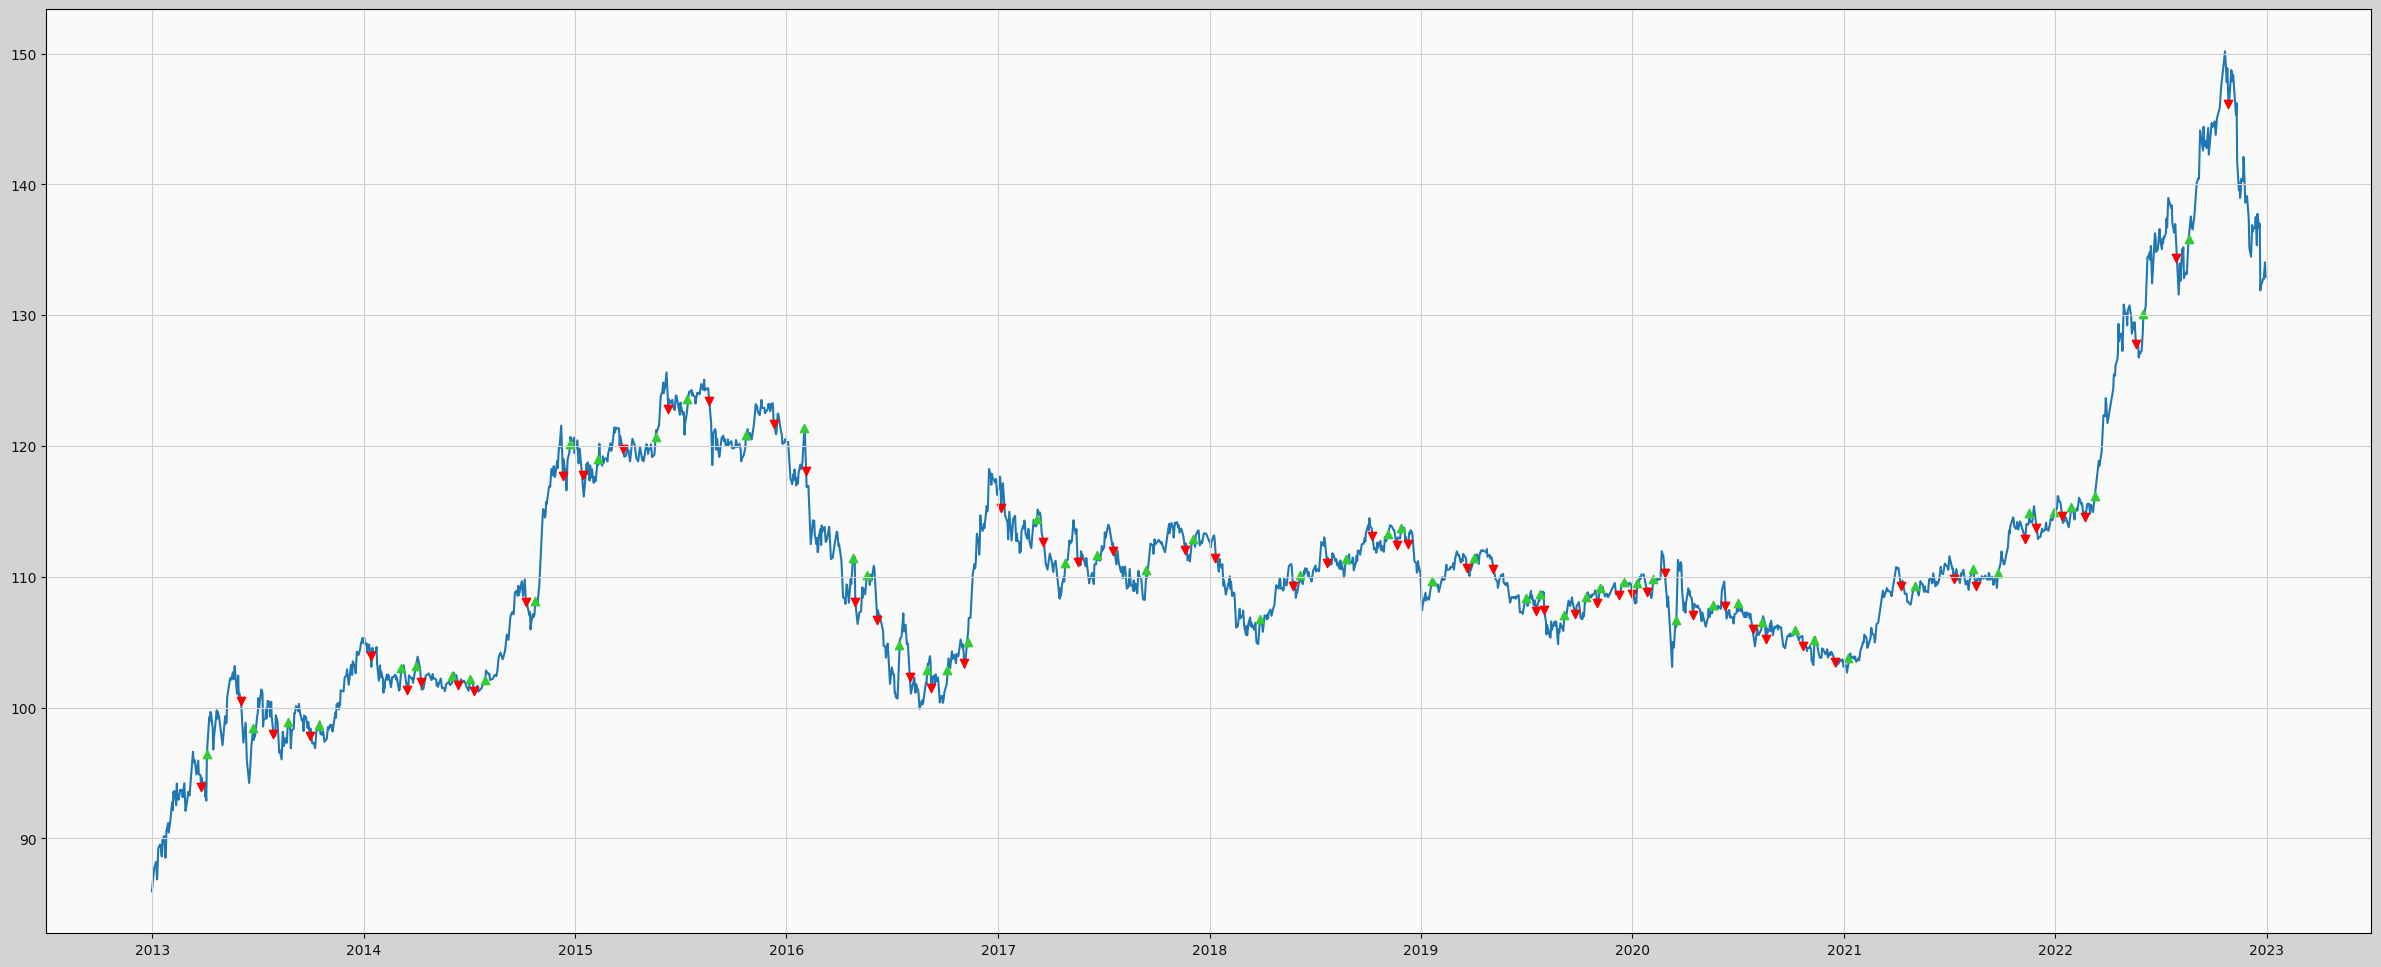

In [32]:
plt.figure(figsize=(30,12))
plt.plot(nnfx_df['Close'], zorder = 1)
plt.scatter(nnfx_df.index, np.where(nnfx_df.buy == 1, nnfx_df['Close'], np.nan), color = 'limegreen', marker = '^')
plt.scatter(nnfx_df.index, np.where(nnfx_df.sell == 1, nnfx_df['Close'], np.nan), color = 'red', marker = 'v')

In [33]:
# Iterate through all currency pairs
stats_nnfx_all = pd.DataFrame()

for k,v in pair_dict.items():
    temp_nnfx = prep_nnfx_data(v)

    def ut_indicators():
        return temp_nnfx.buy.to_numpy(), temp_nnfx.sell.to_numpy()

    def WAE_indicators():
        return temp_nnfx.trend_up.to_numpy(), temp_nnfx.trend_down.to_numpy(), temp_nnfx.el.to_numpy(), temp_nnfx.dead_zone.to_numpy()

    def BPMI_indicators():
        return temp_nnfx.sm_pmi.to_numpy()

    def Baseline_indicators():
        return temp_nnfx.t3.to_numpy(), temp_nnfx.atr_upper.to_numpy(), temp_nnfx.atr_lower.to_numpy()
    
    temp_bt_nnfx = Backtest(temp_nnfx, NNFXStrategy, cash=10000, commission=0.002, trade_on_close=False)
    temp_stats_bt_nnfx = temp_bt_nnfx.run()
    x = pd.DataFrame(temp_stats_bt_nnfx).T
    x['CCY'] = k
    stats_nnfx_all = pd.concat([stats_nnfx_all, x])

In [34]:
temp_bt_nnfx.plot()

GridPlot(id='p2651', ...)

In [35]:
pd.options.display.max_columns = None
stats_nnfx_all

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],Volatility (Ann.) [%],Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max. Drawdown [%],Avg. Drawdown [%],Max. Drawdown Duration,Avg. Drawdown Duration,# Trades,Win Rate [%],Best Trade [%],Worst Trade [%],Avg. Trade [%],Max. Trade Duration,Avg. Trade Duration,Profit Factor,Expectancy [%],SQN,_strategy,_equity_curve,_trades,CCY
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,14.082886,9218.482057,10165.391329,-7.815179,-34.892136,-0.783805,3.395236,0.0,0.0,0.0,-11.013752,-6.705374,3389 days 00:00:00,1710 days 00:00:00,39,28.205128,4.536874,-2.357869,-0.299616,48 days 00:00:00,13 days 00:00:00,0.628352,-0.287455,-0.859971,NNFXStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,AUDUSD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,21.181888,9720.341148,10200.447386,-2.796589,-22.859203,-0.273908,4.624553,0.0,0.0,0.0,-17.893039,-6.445061,3048 days 00:00:00,859 days 00:00:00,51,31.372549,8.108476,-3.034973,-0.194522,53 days 00:00:00,15 days 00:00:00,0.79831,-0.173721,-0.211071,NNFXStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,NZDUSD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,15.96929,9872.688748,12431.276982,-1.273113,158.403005,-0.123871,7.100948,0.0,0.0,0.0,-20.581862,-3.468285,1348 days 00:00:00,159 days 00:00:00,41,41.463415,15.832818,-4.549384,-0.094619,48 days 00:00:00,13 days 00:00:00,0.971703,-0.035287,-0.055925,NNFXStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDBRL=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,14.00614,9008.439741,10105.194344,-9.915603,36.283188,-1.004691,2.427182,0.0,0.0,0.0,-11.080319,-3.807557,3389 days 00:00:00,1133 days 00:00:00,42,38.095238,1.346235,-1.804184,-0.362214,34 days 00:00:00,12 days 00:00:00,0.316299,-0.359255,-2.24192,NNFXStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDCAD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,14.274751,9702.656362,10398.165695,-2.973436,77.191931,-0.291467,4.287279,0.0,0.0,0.0,-15.914011,-4.186131,2632 days 00:00:00,486 days 00:00:00,44,34.090909,11.306696,-3.400371,-0.02699,36 days 00:00:00,14 days 00:00:00,1.004543,0.003817,-0.200554,NNFXStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDNOK=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,18.272553,7417.988065,10357.583923,-25.820119,99.749752,-2.847974,6.355191,0.0,0.0,0.0,-32.95874,-11.461946,3389 days 00:00:00,1133 days 00:00:00,48,27.083333,11.570842,-4.390181,-0.642869,54 days 00:00:00,13 days 00:00:00,0.561127,-0.604196,-1.690359,NNFXStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice ExitP...,USDZAR=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,15.617805,8647.179985,10003.352973,-13.5282,54.625409,-1.395719,2.943175,0.0,0.0,0.0,-13.557184,-6.868927,3438 days 00:00:00,1721 days 00:00:00,49,30.612245,3.552939,-2.017496,-0.349369,38 days 00:00:00,11 days 00:00:00,0.470015,-0.343497,-1.900517,NNFXStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,USDJPY=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,16.730622,10322.363537,11194.7198,3.223635,34.061736,0.307277,3.964426,0.077509,0.117451,0.034006,-9.036057,-2.278258,1098 days 00:00:00,238 days 00:00:00,46,43.478261,5.434528,-1.939316,0.091603,45 days 00:00:00,13 days 00:00:00,1.178008,0.107025,0.260634,NNFXStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,USDGBP=X


# SSL Channel Trading Strategy

In [36]:

def ssl_channel(data, length=10):
    data = data.copy()

    # Calculate SMAs of high and low prices
    data['smaHigh'] = data['High'].rolling(window=length).mean()
    data['smaLow'] = data['Low'].rolling(window=length).mean()

    # Initialize Hlv (Horizontal Line Value)
    data['Hlv'] = np.nan

    # Determine Hlv values
    for i in range(len(data)):
        if pd.notnull(data['Close'].iloc[i]):
            if data['Close'].iloc[i] > data['smaHigh'].iloc[i]:
                data['Hlv'].iloc[i] = 1
            elif data['Close'].iloc[i] < data['smaLow'].iloc[i]:
                data['Hlv'].iloc[i] = -1
            else:
                data['Hlv'].iloc[i] = data['Hlv'].iloc[i - 1]

    # Calculate sslDown and sslUp
    data['sslDown'] = np.where(data['Hlv'] < 0, data['smaHigh'], data['smaLow'])
    data['sslUp'] = np.where(data['Hlv'] < 0, data['smaLow'], data['smaHigh'])

    return data['sslDown'].values, data['sslUp'].values

In [37]:
def kijun_sen(data, period=26):
    data = data.copy()

    # Define function to calculate Donchian channel
    def donchian_channel(data, length):
        lowest_low = data['Low'].rolling(window=length).min()
        highest_high = data['High'].rolling(window=length).max()
        return (lowest_low + highest_high) / 2

    # Calculate Kijun-Sen (base line)
    data['baseline'] = donchian_channel(data, period)

    return data['baseline'].values

In [38]:
def prep_ssl_data(data):
    df = data.copy()
    df['sslDown'], df['sslUp'] = ssl_channel(df)
    df['baseline'] = kijun_sen(df)
    df['trend_up'], df['trend_down'], df['el'], df['dead_zone'] = WAE(df, sensitivity=150, fast_length=20, slow_length=40, channel_length=20, mult=2)
    return df

In [39]:
ssl_df = prep_ssl_data(pair_dict['USDGBP=X'])

In [40]:
def ssl_indicators():
    return ssl_df['sslUp'].to_numpy(), ssl_df['sslDown'].to_numpy()

def kijun_indicators():
    return ssl_df['baseline'].to_numpy()

def WAE_indicators():
    return ssl_df.trend_up.to_numpy(), ssl_df.trend_down.to_numpy(), ssl_df.el.to_numpy(), ssl_df.dead_zone.to_numpy()

class SSLChannelStrategy(TrailingStrategy):
    def init(self):
        super().init()
        self.set_atr_periods(14)
        self.set_trailing_sl(1.5)
        self.sslUp, self.sslDown = self.I(ssl_indicators)
        self.kijun = self.I(kijun_indicators)
        self.trend_up, self.trend_down, self.el, self.deadzone = self.I(WAE_indicators)
        self.atr = self.I(talib.ATR, self.data.High, self.data.Low, self.data.Close, 14)
        self.last_atr = None
        self.last_close = None

    def next(self):
        super().next()
        if crossover(self.sslUp, self.sslDown) and self.data.Close[-1] >= self.kijun and self.trend_up > 0 and self.trend_up > self.el and self.trend_up > self.deadzone:
            self.buy()
            self.last_atr = self.atr[-1]
            self.last_close = self.data.Close[-1]
        elif crossover(self.sslDown, self.sslUp) and self.data.Close[-1] <= self.kijun and self.trend_down > 0 and self.trend_down > self.el and self.trend_down > self.deadzone:
            self.sell()
            self.last_atr = self.atr[-1]
            self.last_close = self.data.Close[-1]
        
        if self.position.is_long and self.last_atr is not None and self.data.Close[-1] >= self.last_atr + self.trades[0].entry_price:
            self.position.close(portion=0.5)
            self.last_atr = None
            self.last_close = None

        elif self.position.is_long and crossover(self.sslDown, self.sslUp):
            self.position.close()

        if self.position.is_short and self.last_atr is not None and self.data.Close[-1] <= self.last_atr + self.trades[0].entry_price:
            self.position.close(portion=0.5)
            self.last_atr = None
            self.last_close = None

        elif self.position.is_short and crossover(self.sslUp, self.sslDown):
            self.position.close()


In [41]:
bt_ssl =  Backtest(ssl_df, SSLChannelStrategy, cash=10000, commission=0.002, trade_on_close=False)
stats_ssl = bt_ssl.run()
stats_ssl

Start                     2012-12-31 00:00:00
End                       2022-12-30 00:00:00
Duration                   3651 days 00:00:00
Exposure Time [%]                   32.425173
Equity Final [$]                  8642.890518
Equity Peak [$]                  10064.469842
Return [%]                         -13.571095
Buy & Hold Return [%]               34.061736
Return (Ann.) [%]                    -1.40045
Volatility (Ann.) [%]                4.003434
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -20.871652
Avg. Drawdown [%]                   -5.595909
Max. Drawdown Duration     3418 days 00:00:00
Avg. Drawdown Duration      888 days 00:00:00
# Trades                                  142
Win Rate [%]                        40.140845
Best Trade [%]                       6.456416
Worst Trade [%]                     -4.097667
Avg. Trade [%]                    

In [42]:
bt_ssl.plot()

GridPlot(id='p3151', ...)

In [43]:
# Iterate through all currency pairs
stats_ssl_all = pd.DataFrame()

for k,v in pair_dict.items():
    temp_ssl = prep_ssl_data(v)

    def ssl_indicators():
        return temp_ssl['sslUp'].to_numpy(), temp_ssl['sslDown'].to_numpy()

    def kijun_indicators():
        return temp_ssl['baseline'].to_numpy()

    def WAE_indicators():
        return temp_ssl.trend_up.to_numpy(), temp_ssl.trend_down.to_numpy(), temp_ssl.el.to_numpy(), temp_ssl.dead_zone.to_numpy()
    
    temp_bt_ssl = Backtest(temp_ssl, SSLChannelStrategy, cash=10000, commission=0.002, trade_on_close=False)
    temp_stats_bt_ssl = temp_bt_ssl.run()
    x = pd.DataFrame(temp_stats_bt_ssl).T
    x['CCY'] = k
    stats_ssl_all = pd.concat([stats_ssl_all, x])

In [44]:
stats_ssl_all

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],Volatility (Ann.) [%],Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max. Drawdown [%],Avg. Drawdown [%],Max. Drawdown Duration,Avg. Drawdown Duration,# Trades,Win Rate [%],Best Trade [%],Worst Trade [%],Avg. Trade [%],Max. Trade Duration,Avg. Trade Duration,Profit Factor,Expectancy [%],SQN,_strategy,_equity_curve,_trades,CCY
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,36.339217,8696.734507,10566.516481,-13.032655,-34.892136,-1.341218,4.866455,0.0,0.0,0.0,-17.695349,-2.756504,2332 days 00:00:00,273 days 00:00:00,156,39.74359,6.332471,-9.256099,0.076082,48 days 00:00:00,10 days 00:00:00,1.165775,0.091282,-1.051379,SSLChannelStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice E...,AUDUSD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,34.650806,7388.623365,10373.903066,-26.113766,-22.859203,-2.884153,4.527268,0.0,0.0,0.0,-30.500519,-4.668521,3488 days 00:00:00,502 days 00:00:00,158,39.873418,5.696911,-3.058065,-0.091167,54 days 00:00:00,9 days 00:00:00,0.878856,-0.07825,-2.477929,SSLChannelStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice E...,NZDUSD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,34.548944,6486.646,10455.612084,-35.13354,158.403005,-4.100711,7.139417,0.0,0.0,0.0,-38.169038,-5.646009,3479 days 00:00:00,511 days 00:00:00,190,36.315789,15.832818,-3.845438,-0.297613,48 days 00:00:00,8 days 00:00:00,0.700585,-0.274183,-2.410883,SSLChannelStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Ex...,USDBRL=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,35.495012,8311.362178,10032.103182,-16.886378,36.283188,-1.772677,2.983423,0.0,0.0,0.0,-19.794735,-6.681012,3537 days 00:00:00,1182 days 00:00:00,154,35.064935,4.52843,-1.799029,-0.067966,51 days 00:00:00,9 days 00:00:00,0.861524,-0.061717,-2.251631,SSLChannelStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Ex...,USDCAD=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,37.52878,7858.749393,10057.407275,-21.412506,77.191931,-2.303122,5.224108,0.0,0.0,0.0,-22.295811,-7.901033,3564 days 00:00:00,1192 days 00:00:00,178,39.88764,7.579623,-9.39184,-0.149436,56 days 00:00:00,9 days 00:00:00,0.799264,-0.135156,-2.071611,SSLChannelStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Ex...,USDNOK=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,37.120921,10910.942445,11042.124709,9.109424,99.749752,0.84693,6.203381,0.136527,0.200513,0.050913,-16.634953,-2.574556,3249 days 00:00:00,298 days 00:00:00,151,56.953642,7.317935,-3.972986,0.408487,48 days 00:00:00,10 days 00:00:00,1.702743,0.431638,0.566247,SSLChannelStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Ex...,USDZAR=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,34.420568,8383.797314,10069.026096,-16.162027,54.625409,-1.690219,3.359918,0.0,0.0,0.0,-19.504746,-6.690313,3550 days 00:00:00,1186 days 00:00:00,174,39.08046,9.667301,-2.468365,-0.050994,50 days 00:00:00,8 days 00:00:00,0.901338,-0.042982,-1.89266,SSLChannelStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Ex...,USDJPY=X
0,2012-12-31 00:00:00,2022-12-30 00:00:00,3651 days 00:00:00,32.425173,8642.890518,10064.469842,-13.571095,34.061736,-1.40045,4.003434,0.0,0.0,0.0,-20.871652,-5.595909,3418 days 00:00:00,888 days 00:00:00,142,40.140845,6.456416,-4.097667,-0.008372,42 days 00:00:00,9 days 00:00:00,1.003932,0.002076,-1.580858,SSLChannelStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Ex...,USDGBP=X


# RSIPCA Strategy

In [40]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from typing import List
import seaborn as sns
from scipy import linalg as la
import matplotlib.pyplot as plt


def pca_linear_model(x: pd.DataFrame, y: pd.Series, n_components: int, thresh: float= 0.01):
    # Center data at 0
    means = x.mean()
    x -= means
    x = x.dropna()

    # Find covariance and compute eigen vectors
    cov = np.cov(x, rowvar=False)
    evals , evecs = la.eigh(cov)
    # Sort eigenvectors by size of eigenvalue
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]

    # Create data set for model
    model_data = pd.DataFrame()
    for j in range(n_components):
         model_data['PC' + str(j)] = pd.Series( np.dot(x, evecs[j]) , index=x.index)
    
    cols = list(model_data.columns)
    model_data['target'] = y
    model_coefs = la.lstsq(model_data[cols], y)[0]
    model_data['pred'] = np.dot( model_data[cols], model_coefs)

    l_thresh = model_data['pred'].quantile(0.99)
    s_thresh = model_data['pred'].quantile(0.01)

    return model_coefs, evecs, means, l_thresh, s_thresh, model_data


def pca_rsi_model(
        ohlc: pd.DataFrame, rsi_lbs: List[int], train_size: int, step_size: int,  
        n_components: int = 2, lookahead: int = 6
):    
    rsis = pd.DataFrame()
    for lb in rsi_lbs:
        rsis[lb] = ta.rsi(ohlc['Close'], lb)

    warm_up = max(rsi_lbs) * 2
    next_train = warm_up + train_size
    tar = np.log(ohlc['Close']).diff(lookahead).shift(-lookahead)

    # Outputs
    model_pred = np.zeros(len(ohlc))
    long_thresh = np.zeros(len(ohlc))
    short_thresh = np.zeros(len(ohlc))
    signal = np.zeros(len(ohlc))

    model_pred[:] = np.nan
    long_thresh[:] = np.nan
    short_thresh[:] = np.nan

    rsi_means = None
    evecs = None
    model_coefs = None
    l_thresh = None
    s_thresh = None
    for i in range(next_train, len(ohlc)):
        if i == next_train:
            # Get RSI values in window, prevent future leak
            train_data = rsis.iloc[i - train_size: i + 1 - lookahead].copy()
            y = tar.reindex(train_data.index)
            
            model_coefs, evecs, rsi_means, l_thresh, s_thresh, _ =  pca_linear_model(train_data, y, n_components)
            next_train += step_size
        
        curr_row = rsis.iloc[i] - rsi_means
        vec = np.zeros(n_components)
        for j in range(n_components):
            vec[j] = np.dot(curr_row, evecs[j])
        curr_pred = np.dot(vec, model_coefs)

        model_pred[i] = curr_pred
        long_thresh[i] = l_thresh 
        short_thresh[i] = s_thresh
        if curr_pred > l_thresh:
            signal[i] = 1
        elif curr_pred < s_thresh:
            signal[i] = -1

    # Output dataframe
    output_df = pd.DataFrame(index=ohlc.index)
    output_df['pred'] = model_pred
    output_df['long_thresh'] = long_thresh
    output_df['short_thresh'] = short_thresh
    output_df['signal'] = signal
    # Keep signals normalized to -1 1
    output_df['rolling_signal'] = output_df['signal'].rolling(lookahead).mean()
    output_df['rolling_signal'] = np.where(output_df['rolling_signal'] != 0, np.sign(output_df['rolling_signal']), 0)    
    return output_df


In [8]:
pair_dict['USDTHB=X']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-31,29.893000,30.614000,29.874001,29.898001,29.898001,0
2013-01-01,30.573000,30.662001,30.542000,30.580000,30.580000,0
2013-01-02,30.544001,30.575001,30.236000,30.549000,30.549000,0
2013-01-03,30.304001,30.393999,30.268999,30.292999,30.292999,0
2013-01-04,30.395000,30.525000,30.354000,30.391001,30.391001,0
...,...,...,...,...,...,...
2022-12-26,34.609001,34.779999,34.595001,34.609001,34.609001,0
2022-12-27,34.660000,34.676998,34.550999,34.660000,34.660000,0
2022-12-28,34.619999,34.790001,34.578999,34.619999,34.619999,0


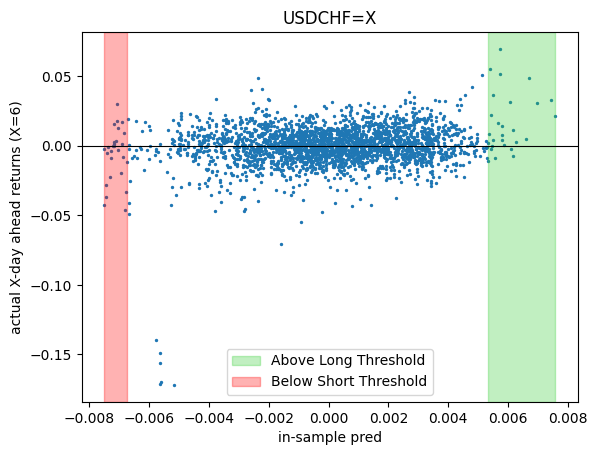

In [83]:
all_outputs = {}
for k, v in pair_dict.items():
    data = v.copy()
    ######################## Walkforward ###########################    
    # lookahead = 6
    # output = pca_rsi_model(data, list(range(2, 25)), round(len(data)-1), 1, n_components=3, lookahead=lookahead)
    # output['t'] = np.log(data['Close']).diff(lookahead).shift(-lookahead)

    # print("Mean Target Above Long Threshold", output[output['pred'] > output['long_thresh']]['t'].mean())
    # print("Mean Target Below Short Threshold", output[output['pred'] < output['short_thresh']]['t'].mean())

    # next_r = np.log(data['Close']).diff().shift(-1)
    # data['strat_ret'] = next_r * output['signal']

    # # Profit fac
    # pf = data[data['strat_ret'] > 0]['strat_ret'].sum() / data[data['strat_ret'] < 0]['strat_ret'].abs().sum()
    # print("Profit Factor",pf)

    # plt.style.use("dark_background")

    # data['r'] = next_r

    # # data = data[data.index > '2020-01-01']
    # # output = output[output.index > '2020-01-01']

    # fig, axs = plt.subplots(2, 1, sharex=True)
    # data['strat_ret'].cumsum().plot(label='RSI-PSA 3-6 Model', ax=axs[0])
    # print(k)
    # output['pred'].plot(ax=axs[1])
    # output['long_thresh'].plot(ax=axs[1], color='green')
    # output['short_thresh'].plot(ax=axs[1], color='red')
    # all_outputs[k] = output

    ######################## In-sample ########################### 
    if k == 'USDCHF=X':
        rsi_periods = list(range(2, 25))
        rsis = pd.DataFrame()
        for p in rsi_periods:
            rsis[p] = ta.rsi(data['Close'], p)

        target = np.log(data['Close']).diff(6).shift(-6)

        # Drop nans
        rsis['tar'] = target
        rsis = rsis.dropna()
        target = rsis['tar']
        rsis = rsis.drop('tar',axis=1)
        coefs,_, means, l_thresh, s_thresh, model_data =  pca_linear_model(rsis, target, 3)

        plt.style.use('default')
        model_data.plot.scatter('pred', 'target',s = 2)
        plt.axhline(0.0, color='black', linewidth = 0.8)
        plt.axvspan(l_thresh, max(model_data['pred']), color='limegreen', alpha=0.3, label='Above Long Threshold')
        plt.axvspan(min(model_data['pred']),s_thresh, color='red', alpha=0.3, label='Below Short Threshold')
        plt.ylabel('actual X-day ahead returns (X=6)')
        plt.xlabel('in-sample pred')
        plt.title(k)
        plt.legend()
        plt.show()
        

<Figure size 2000x800 with 0 Axes>

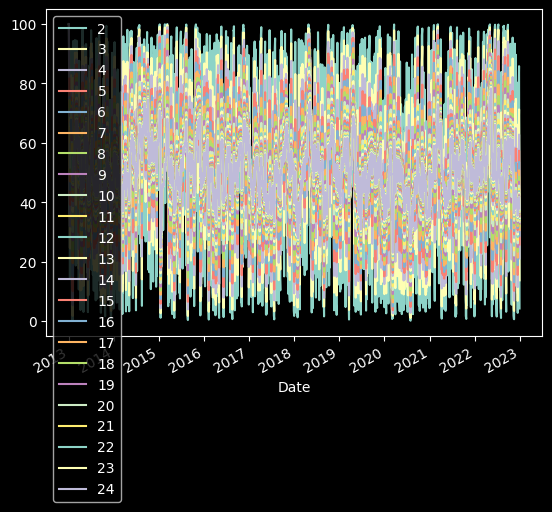

Text(50.722222222222214, 0.5, 'RSI Period')

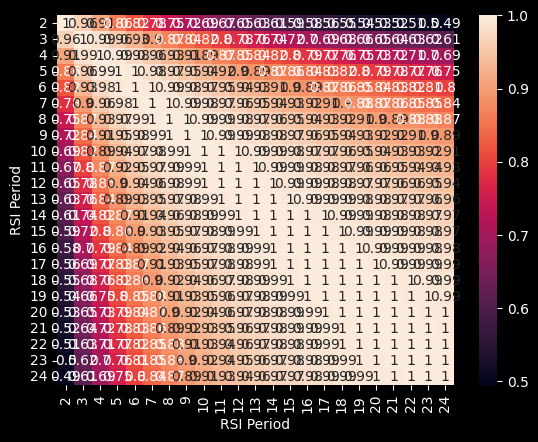

In [47]:
rsi_periods = list(range(2, 25))

rsis = pd.DataFrame()
for p in rsi_periods:
    rsis[p] = ta.rsi(pair_dict['USDCHF=X']['Close'], p)

plt.style.use('dark_background')

# rsis.hist(bins=100)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
# plt.show()
plt.figure(figsize=(20,8))
rsis.plot()
plt.show()


sns.heatmap(rsis.corr(), annot=True)
plt.xlabel("RSI Period")
plt.ylabel("RSI Period")

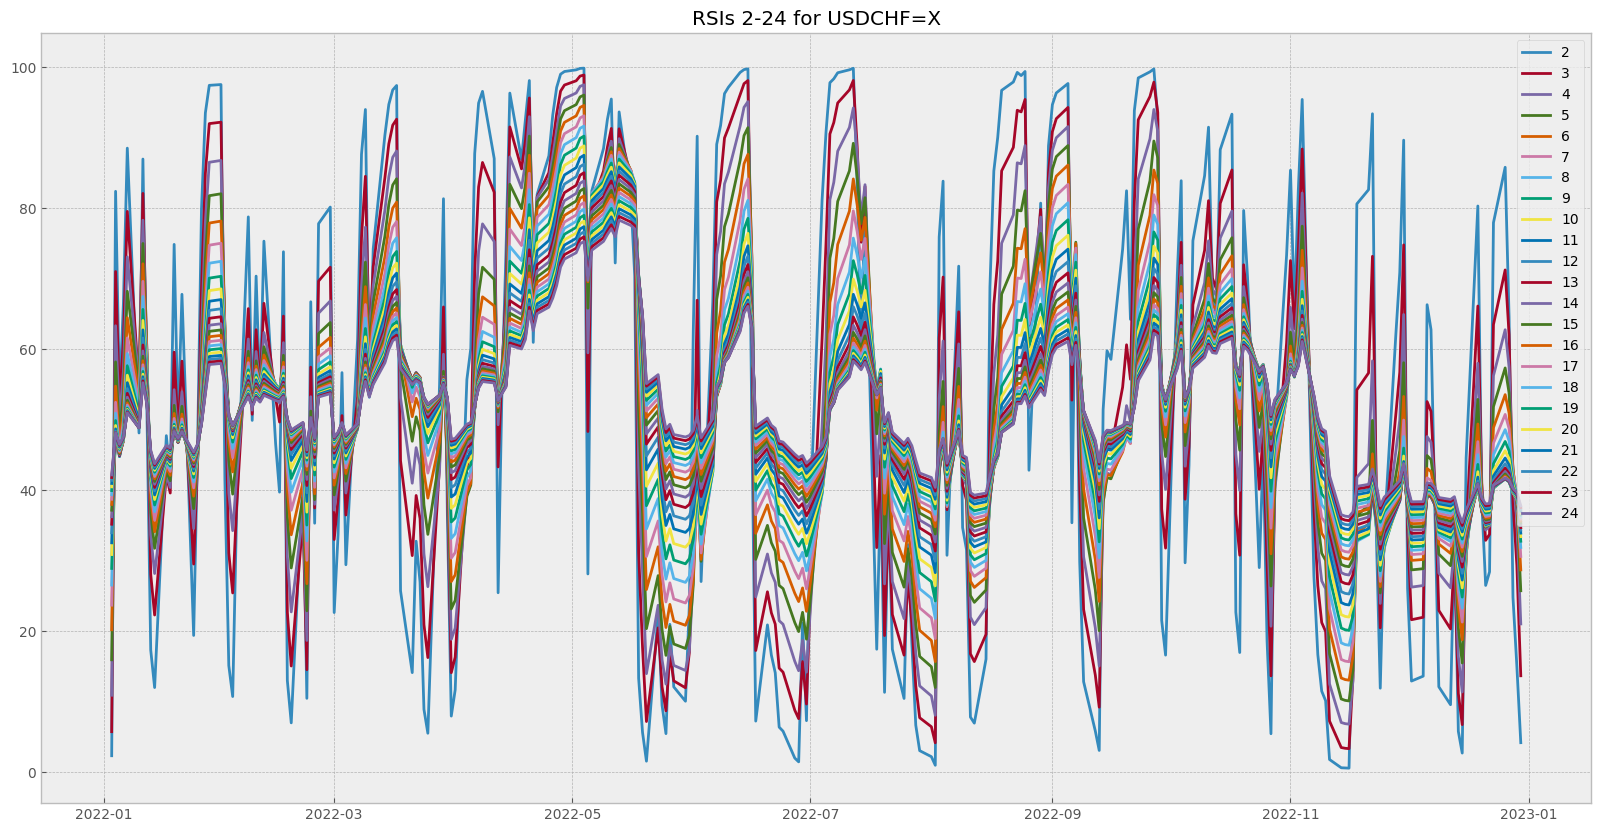

In [68]:
plt.style.use('bmh')
plt.figure(figsize=(20,10))
plt.plot(rsis[rsis.index>='2022-01-01'], label = rsis.columns)
plt.legend()
plt.title("RSIs 2-24 for USDCHF=X")
plt.show()

In [61]:
rsis

,2,3,4,5,6,7,8,9,10,11,...,15,16,17,18,19,20,21,22,23,24
Date,,,,,,,,,,,,,,,,,,,,,
2012-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,85.799358,71.238029,62.758229,57.340054,53.553737,50.747158,48.594620,46.915697,45.598255,44.564951,...,42.295836,42.031180,41.843228,41.717037,41.640537,41.603977,41.599478,41.620664,41.662376,41.720432
2022-12-27,64.523910,62.092007,57.480321,53.794093,50.957016,48.739068,46.981376,45.581706,44.469466,43.591482,...,41.677886,41.465469,41.321454,41.232641,41.188271,41.179591,41.199488,41.242190,41.303009,41.378143
2022-12-28,24.799404,38.280674,42.197355,43.046402,42.895434,42.414574,41.852545,41.313264,40.841095,40.452027,...,39.672048,39.627895,39.625726,39.657818,39.717541,39.799299,39.898426,40.011061,40.134035,40.264758


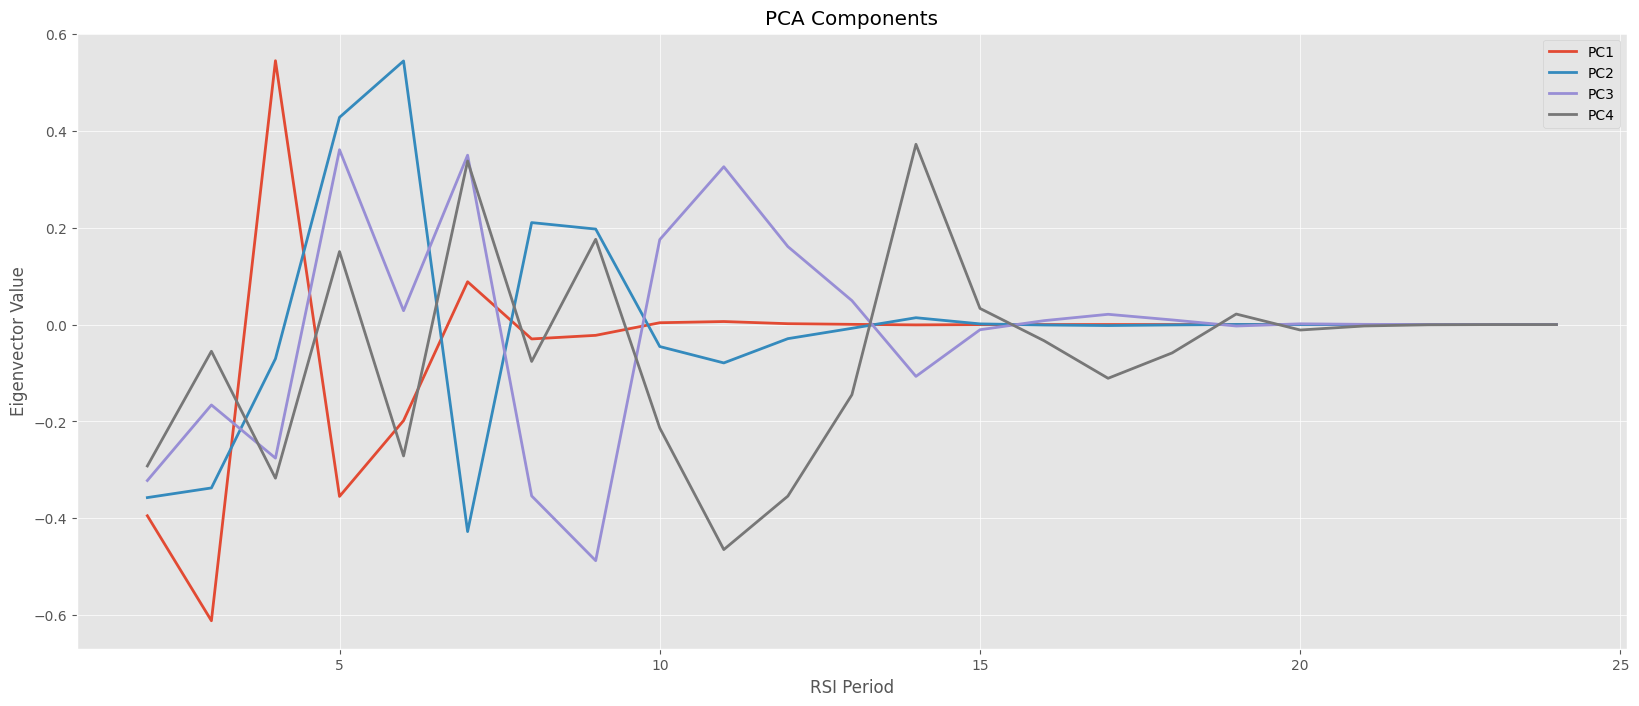

In [67]:
# Find covariance and compute eigen vectors
rsis2 = rsis.dropna()
cov = np.cov(rsis2, rowvar=False)
evals , evecs = la.eigh(cov)
# Sort eigenvectors by size of eigenvalue
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
evals = evals[idx]

n_components = 4
rsi_pca = pd.DataFrame()
for j in range(n_components):
    rsi_pca['PC' + str(j)] = pd.Series( np.dot(rsis2, evecs[j]) , index=rsis2.index)

plt.style.use('ggplot')
plt.figure(figsize=(20,8))
for j in range(n_components):
    pd.Series(evecs[j], index=rsi_periods).plot(label='PC' + str(j+1))
plt.xlabel("RSI Period")
plt.ylabel("Eigenvector Value")
plt.title('PCA Components')
plt.legend()
plt.show()

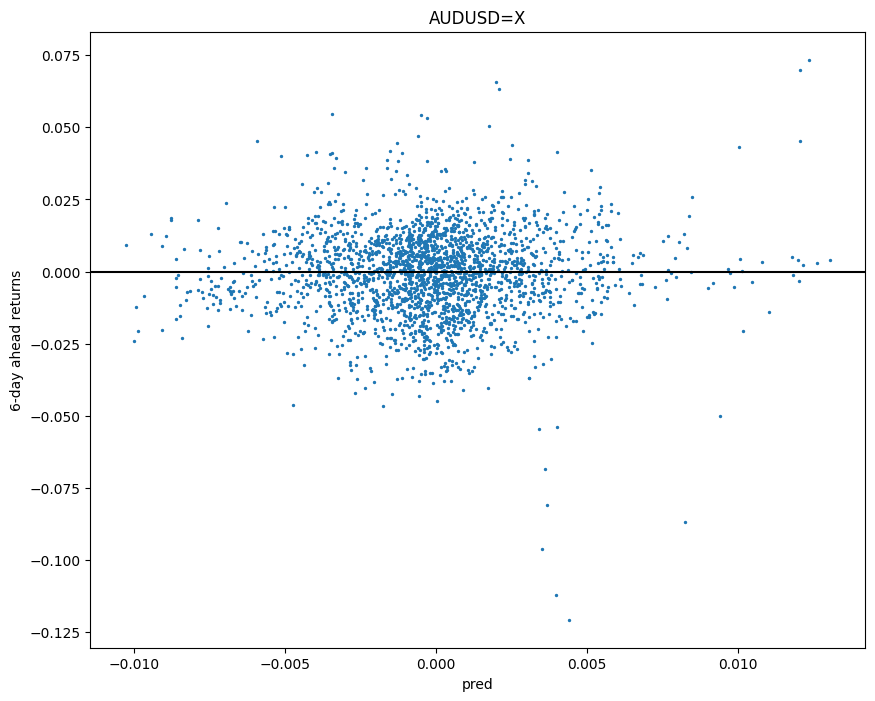

In [34]:
a = all_outputs['AUDUSD=X']
plt.figure(figsize=(10,8))
plt.style.use("default")
plt.scatter(a['pred'], a['t'], s = 2)
plt.axhline(y=0, color= 'k')
plt.xlabel('pred')
plt.ylabel('6-day ahead returns')
plt.title('AUDUSD=X')
plt.show()

**Observations**
- model does not seem to work well in range-bound market --> is this an issue of tweaking the time ranges of the input variables?
- may need more conditions to achieve a better entry or exit point
- **TO VET**: To check if python implementation vs. original is correct. python implementation was copied over to another folder instead of pip install as there were errors with the implementation online. Check Classifier.py line 268 vs. original https://www.tradingview.com/script/WhBzgfDu-Machine-Learning-Lorentzian-Classification/ line 324. Model is supposed to predict direction in next 4 bars but the shifting from python implementation looks suspicious